In [42]:
def create_features_custom(path, label='pose', npts=50):

    import glob
    import os
    import re
    from PIL import Image

    # path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
    png_files = glob.glob(os.path.join(path, '*.png'))
    json_files = glob.glob(os.path.join(path, '*.json'))

    def extract_png_number(filename):
        match = re.search(r'(\d+).png$', filename)
        if match:   return int(match.group(1))
        else:       return -1
        
    def extract_json_number(filename):
        match = re.search(r'(\d+).json$', filename)
        if match:   return int(match.group(1))
        else:       return -1

    png_files.sort(key=extract_png_number)
    json_files.sort(key=extract_json_number)

    ## get the translations (YVALS) from the json files

    import os
    import json
    import numpy as np

    translations = []
    for json_f in json_files:
        with open(json_f) as f: translations.append(json.load(f)[label])

    translations = np.array(translations, dtype=np.float32)
    y_vals = translations


    # extract dimensions (XVALS) from the data
    from skimage.color import rgb2gray
    def model_dimensions(img_np:np.ndarray):

        # create object mask
        img_np_copy = img_np.copy()
        img_np_copy[np.where(img_np_copy<0.01)] = 0
        img_np_copy[np.where(img_np_copy>0.01)] = 1

        # determine object dimensions
        y,x,c = np.where(img_np_copy>0)
        try:
            ymin, ymax = np.min(y), np.max(y)
            xmin, xmax = np.min(x), np.max(x)
        except:
            ymin, ymax = 0, 0
            xmin, xmax = 0, 0
        height = ymax - ymin
        width = xmax - xmin

        # determine vertical-wise pixel sums
        img_np_copy_bw = rgb2gray(img_np_copy.copy())
        horiz_sums = np.sum(img_np_copy_bw, axis=0)
        horiz_sums = horiz_sums/np.max(horiz_sums)
        # horiz_sums = (horiz_sums - np.mean(horiz_sums))/np.std(horiz_sums)
        horiz_sums = horiz_sums[horiz_sums>0.01]
        horiz_sums = [i for i in horiz_sums]

        # determine horiz-wise pixel sums
        vert_sums = np.sum(img_np_copy_bw, axis=1)
        vert_sums = vert_sums/np.max(vert_sums)
        # vert_sums = (vert_sums - np.mean(vert_sums))/np.std(vert_sums)
        vert_sums = vert_sums[vert_sums>0.01]
        vert_sums = [i for i in vert_sums]

        # turn the horizontal and vertical sums into a spline, and sample 20 points
        from scipy.interpolate import UnivariateSpline
        horiz_spline = UnivariateSpline(range(len(horiz_sums)), horiz_sums)
        vert_spline = UnivariateSpline(range(len(vert_sums)), vert_sums)
        horiz_spline.set_smoothing_factor(0.5)
        vert_spline.set_smoothing_factor(0.5)

        values_to_query = np.linspace(0, len(horiz_sums), npts)
        horiz_spline_vals = horiz_spline(values_to_query)

        values_to_query = np.linspace(0, len(vert_sums), npts)
        vert_spline_vals  = vert_spline(values_to_query)

        # return [height, width, ymin, ymax, xmin, xmax] + list(horiz_spline_vals) + list(vert_spline_vals)
        return [height, width] + list(horiz_spline_vals) + list(vert_spline_vals)



    import tqdm
    dimensions = []
    for png_f in tqdm.tqdm(png_files, desc='loading x vals'):
        img = Image.open(png_f).convert('RGB')
        img_np = np.array(img)/255.0
        dimensions.append(model_dimensions(img_np))
    dimensions = np.array(dimensions, dtype=np.float32)
    xvals = dimensions

    # split into train and test
    from sklearn.model_selection import train_test_split
    train_indices, test_indices = train_test_split(range(len(xvals)), test_size=0.2, random_state=42)
    return xvals, y_vals, train_indices, test_indices


loading x vals: 100%|██████████| 10000/10000 [01:29<00:00, 112.30it/s]


lp score on test, mlp [[ 60.96893]
 [ 87.72998]
 [104.62484]
 ...
 [167.55681]
 [164.61565]
 [160.0508 ]]


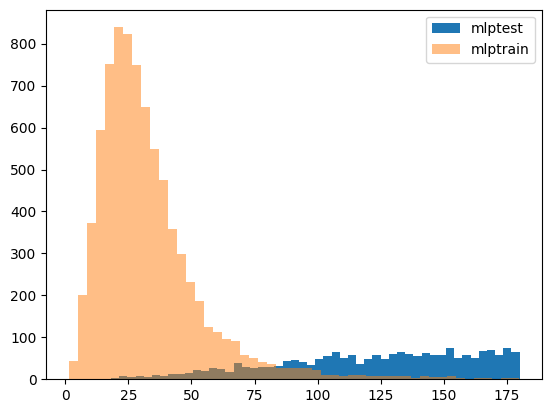

lp score on test, mlp [[ 65.562  ]
 [ 97.32317]
 [171.35176]
 ...
 [162.75806]
 [113.94178]
 [ 78.92216]]


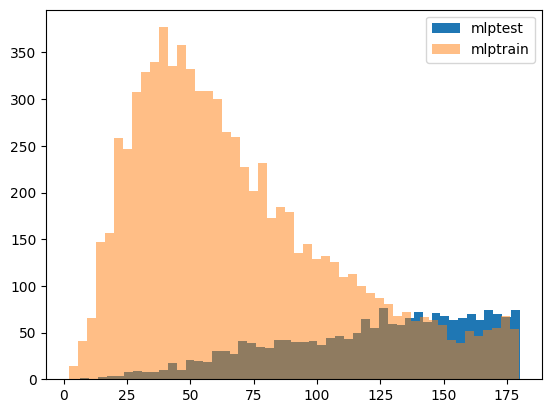

lp score on test, mlp [[ 87.651085]
 [146.0685  ]
 [124.56776 ]
 ...
 [114.59095 ]
 [163.97818 ]
 [125.6659  ]]


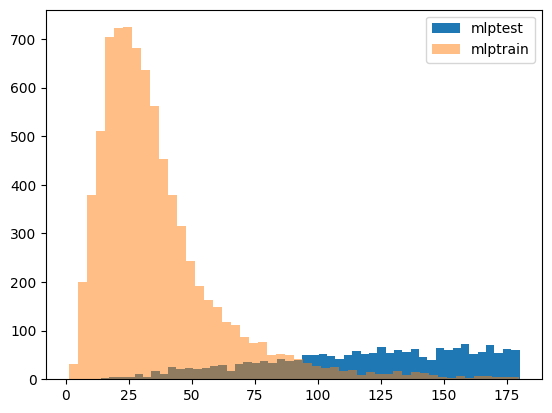

In [34]:

xvals, yvals, train_indices, test_indices = create_features_custom(path='/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random10k_FORFILTERING/data', label='pose', npts=50)
# and in using offsets?

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

x_vals = xvals
y_vals = yvals
scaler = StandardScaler()
scaler.fit(x_vals[train_indices])
x_train = scaler.transform(x_vals[train_indices])
x_test = scaler.transform(x_vals[test_indices])

clf = MLPRegressor([200, 200, 100], random_state=1, max_iter=500).fit(x_train, y_vals[train_indices])
y_pred = clf.predict(x_test)

import numpy as np
def geodesic_rot_distance(target, pred):
    target = target/np.linalg.norm(target, axis=-1, keepdims=True)
    pred = pred/np.linalg.norm(pred, axis=-1, keepdims=True)

    inner_prod = np.sum(target*pred, axis=-1, keepdims=True)
    loss = np.arccos(np.clip(2*inner_prod**2 - 1, -1, 1))
    return loss

import matplotlib.pyplot as plt
name = 'mlp'
print(f'lp score on test, {name}', geodesic_rot_distance(y_vals[test_indices], y_pred)*180/np.pi)
plt.hist(geodesic_rot_distance(y_vals[test_indices], clf.predict(x_test))*180/np.pi, bins=50, alpha=1, label=name+'test');
plt.hist(geodesic_rot_distance(y_vals[train_indices], clf.predict(x_train))*180/np.pi, bins=50, alpha=0.5, label=name+'train');

plt.legend()
plt.show()

# and in using offsets?

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

x_vals = xvals
y_vals = yvals
scaler = StandardScaler()
scaler.fit(x_vals[train_indices])
x_train = scaler.transform(x_vals[train_indices])
x_test = scaler.transform(x_vals[test_indices])

clf = MLPRegressor([200, 100], random_state=1, max_iter=500).fit(x_train, y_vals[train_indices])
y_pred = clf.predict(x_test)

import numpy as np
def geodesic_rot_distance(target, pred):
    target = target/np.linalg.norm(target, axis=-1, keepdims=True)
    pred = pred/np.linalg.norm(pred, axis=-1, keepdims=True)

    inner_prod = np.sum(target*pred, axis=-1, keepdims=True)
    loss = np.arccos(np.clip(2*inner_prod**2 - 1, -1, 1))
    return loss

import matplotlib.pyplot as plt
name = 'mlp'
print(f'lp score on test, {name}', geodesic_rot_distance(y_vals[test_indices], y_pred)*180/np.pi)
plt.hist(geodesic_rot_distance(y_vals[test_indices], clf.predict(x_test))*180/np.pi, bins=50, alpha=1, label=name+'test');
plt.hist(geodesic_rot_distance(y_vals[train_indices], clf.predict(x_train))*180/np.pi, bins=50, alpha=0.5, label=name+'train');

plt.legend()
plt.show()


# and in using offsets?

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

x_vals = xvals
y_vals = yvals
scaler = StandardScaler()
scaler.fit(x_vals[train_indices])
x_train = scaler.transform(x_vals[train_indices])
x_test = scaler.transform(x_vals[test_indices])

clf = MLPRegressor([1000, 100], random_state=1, max_iter=500).fit(x_train, y_vals[train_indices])
y_pred = clf.predict(x_test)

import numpy as np
def geodesic_rot_distance(target, pred):
    target = target/np.linalg.norm(target, axis=-1, keepdims=True)
    pred = pred/np.linalg.norm(pred, axis=-1, keepdims=True)

    inner_prod = np.sum(target*pred, axis=-1, keepdims=True)
    loss = np.arccos(np.clip(2*inner_prod**2 - 1, -1, 1))
    return loss

import matplotlib.pyplot as plt
name = 'mlp'
print(f'lp score on test, {name}', geodesic_rot_distance(y_vals[test_indices], y_pred)*180/np.pi)
plt.hist(geodesic_rot_distance(y_vals[test_indices], clf.predict(x_test))*180/np.pi, bins=50, alpha=1, label=name+'test');
plt.hist(geodesic_rot_distance(y_vals[train_indices], clf.predict(x_train))*180/np.pi, bins=50, alpha=0.5, label=name+'train');

plt.legend()
plt.show()


loading x vals: 100%|██████████| 10000/10000 [01:31<00:00, 108.89it/s]


lp score on test, mlp [[ 47.53727 ]
 [ 88.83732 ]
 [124.030945]
 ...
 [ 57.008217]
 [125.85242 ]
 [ 38.796627]]


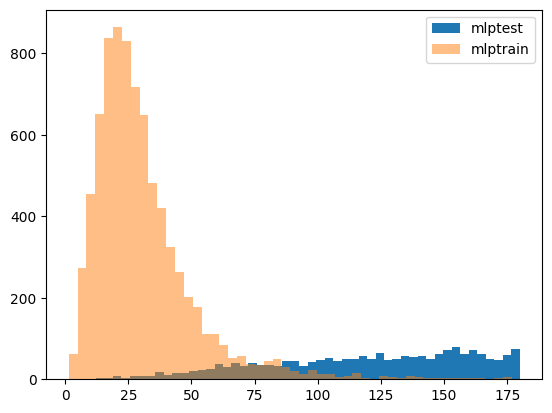

lp score on test, mlp [[179.43976]
 [124.12432]
 [103.78865]
 ...
 [173.8862 ]
 [159.93872]
 [120.7003 ]]


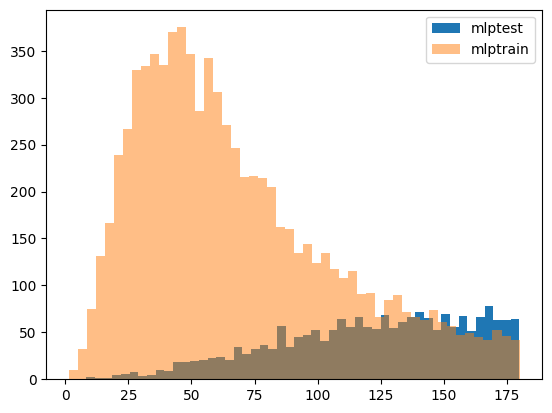

lp score on test, mlp [[ 43.091534]
 [134.90076 ]
 [109.362434]
 ...
 [152.49307 ]
 [160.22438 ]
 [ 64.27073 ]]


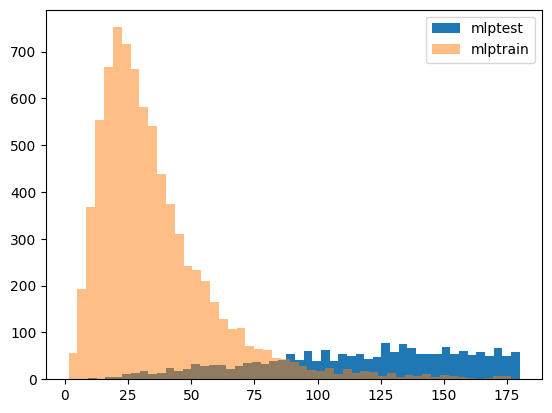

In [35]:

xvals, yvals, train_indices, test_indices = create_features_custom(path='/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data', label='pose', npts=20)
# and in using offsets?

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

x_vals = xvals
y_vals = yvals
scaler = StandardScaler()
scaler.fit(x_vals[train_indices])
x_train = scaler.transform(x_vals[train_indices])
x_test = scaler.transform(x_vals[test_indices])

clf = MLPRegressor([200, 200, 100], random_state=1, max_iter=500).fit(x_train, y_vals[train_indices])
y_pred = clf.predict(x_test)

import numpy as np
def geodesic_rot_distance(target, pred):
    target = target/np.linalg.norm(target, axis=-1, keepdims=True)
    pred = pred/np.linalg.norm(pred, axis=-1, keepdims=True)

    inner_prod = np.sum(target*pred, axis=-1, keepdims=True)
    loss = np.arccos(np.clip(2*inner_prod**2 - 1, -1, 1))
    return loss

import matplotlib.pyplot as plt
name = 'mlp'
print(f'lp score on test, {name}', geodesic_rot_distance(y_vals[test_indices], y_pred)*180/np.pi)
plt.hist(geodesic_rot_distance(y_vals[test_indices], clf.predict(x_test))*180/np.pi, bins=50, alpha=1, label=name+'test');
plt.hist(geodesic_rot_distance(y_vals[train_indices], clf.predict(x_train))*180/np.pi, bins=50, alpha=0.5, label=name+'train');

plt.legend()
plt.show()

# and in using offsets?

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

x_vals = xvals
y_vals = yvals
scaler = StandardScaler()
scaler.fit(x_vals[train_indices])
x_train = scaler.transform(x_vals[train_indices])
x_test = scaler.transform(x_vals[test_indices])

clf = MLPRegressor([200, 100], random_state=1, max_iter=500).fit(x_train, y_vals[train_indices])
y_pred = clf.predict(x_test)

import numpy as np
def geodesic_rot_distance(target, pred):
    target = target/np.linalg.norm(target, axis=-1, keepdims=True)
    pred = pred/np.linalg.norm(pred, axis=-1, keepdims=True)

    inner_prod = np.sum(target*pred, axis=-1, keepdims=True)
    loss = np.arccos(np.clip(2*inner_prod**2 - 1, -1, 1))
    return loss

import matplotlib.pyplot as plt
name = 'mlp'
print(f'lp score on test, {name}', geodesic_rot_distance(y_vals[test_indices], y_pred)*180/np.pi)
plt.hist(geodesic_rot_distance(y_vals[test_indices], clf.predict(x_test))*180/np.pi, bins=50, alpha=1, label=name+'test');
plt.hist(geodesic_rot_distance(y_vals[train_indices], clf.predict(x_train))*180/np.pi, bins=50, alpha=0.5, label=name+'train');

plt.legend()
plt.show()


# and in using offsets?

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

x_vals = xvals
y_vals = yvals
scaler = StandardScaler()
scaler.fit(x_vals[train_indices])
x_train = scaler.transform(x_vals[train_indices])
x_test = scaler.transform(x_vals[test_indices])

clf = MLPRegressor([1000, 100], random_state=1, max_iter=500).fit(x_train, y_vals[train_indices])
y_pred = clf.predict(x_test)

import numpy as np
def geodesic_rot_distance(target, pred):
    target = target/np.linalg.norm(target, axis=-1, keepdims=True)
    pred = pred/np.linalg.norm(pred, axis=-1, keepdims=True)

    inner_prod = np.sum(target*pred, axis=-1, keepdims=True)
    loss = np.arccos(np.clip(2*inner_prod**2 - 1, -1, 1))
    return loss

import matplotlib.pyplot as plt
name = 'mlp'
print(f'lp score on test, {name}', geodesic_rot_distance(y_vals[test_indices], y_pred)*180/np.pi)
plt.hist(geodesic_rot_distance(y_vals[test_indices], clf.predict(x_test))*180/np.pi, bins=50, alpha=1, label=name+'test');
plt.hist(geodesic_rot_distance(y_vals[train_indices], clf.predict(x_train))*180/np.pi, bins=50, alpha=0.5, label=name+'train');

plt.legend()
plt.show()


loading x vals: 100%|██████████| 10000/10000 [01:17<00:00, 128.72it/s]


lp score on test, mlp [ 83.23062 176.88135  33.71654 ...  73.55829 176.876   166.89554]


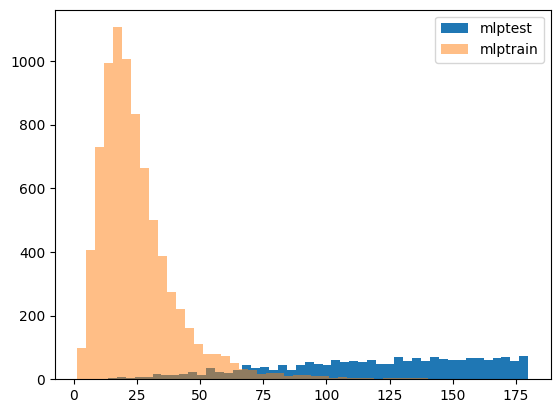

lp score on test, mlp [ 91.64891 179.1466  138.4133  ... 158.57828 167.67221  42.71252]


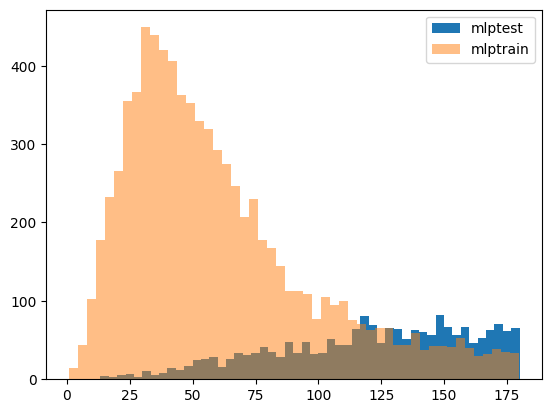

lp score on test, mlp [171.33713   89.702675 173.1522   ...  59.539494 154.76453  126.91067 ]


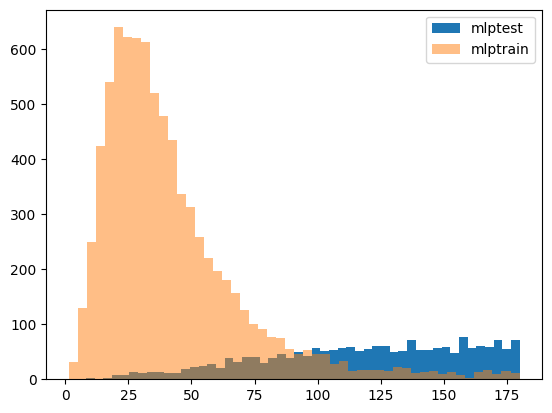

In [41]:

xvals, yvals, train_indices, test_indices = create_features_custom(path='/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random10k_FORFILTERING/data', label='pose', npts=30)
# and in using offsets?

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

x_vals = xvals
y_vals = yvals
scaler = StandardScaler()
scaler.fit(x_vals[train_indices])
x_train = scaler.transform(x_vals[train_indices])
x_test = scaler.transform(x_vals[test_indices])

clf = MLPRegressor([200, 200, 100], random_state=1, max_iter=500).fit(x_train, y_vals[train_indices])
y_pred = clf.predict(x_test)

import numpy as np
def geodesic_rot_distance(target, pred):
    target = target/np.linalg.norm(target, axis=-1)[..., np.newaxis]
    pred = pred/np.linalg.norm(pred, axis=-1)[..., np.newaxis]
    return np.arccos(np.clip(2*np.sum(pred*target, axis=-1)**2 - 1, -1, 1))



import matplotlib.pyplot as plt
name = 'mlp'
print(f'lp score on test, {name}', geodesic_rot_distance(y_vals[test_indices], y_pred)*180/np.pi)
plt.hist(geodesic_rot_distance(y_vals[test_indices], clf.predict(x_test))*180/np.pi, bins=50, alpha=1, label=name+'test');
plt.hist(geodesic_rot_distance(y_vals[train_indices], clf.predict(x_train))*180/np.pi, bins=50, alpha=0.5, label=name+'train');

plt.legend()
plt.show()

# and in using offsets?

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

x_vals = xvals
y_vals = yvals
scaler = StandardScaler()
scaler.fit(x_vals[train_indices])
x_train = scaler.transform(x_vals[train_indices])
x_test = scaler.transform(x_vals[test_indices])

clf = MLPRegressor([200, 100], random_state=1, max_iter=500).fit(x_train, y_vals[train_indices])
y_pred = clf.predict(x_test)

import numpy as np
def geodesic_rot_distance(target, pred):
    target = target/np.linalg.norm(target, axis=-1)[..., np.newaxis]
    pred = pred/np.linalg.norm(pred, axis=-1)[..., np.newaxis]
    return np.arccos(np.clip(2*np.sum(pred*target, axis=-1)**2 - 1, -1, 1))

import matplotlib.pyplot as plt
name = 'mlp'
print(f'lp score on test, {name}', geodesic_rot_distance(y_vals[test_indices], y_pred)*180/np.pi)
plt.hist(geodesic_rot_distance(y_vals[test_indices], clf.predict(x_test))*180/np.pi, bins=50, alpha=1, label=name+'test');
plt.hist(geodesic_rot_distance(y_vals[train_indices], clf.predict(x_train))*180/np.pi, bins=50, alpha=0.5, label=name+'train');

plt.legend()
plt.show()


# and in using offsets?

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

x_vals = xvals
y_vals = yvals
scaler = StandardScaler()
scaler.fit(x_vals[train_indices])
x_train = scaler.transform(x_vals[train_indices])
x_test = scaler.transform(x_vals[test_indices])

clf = MLPRegressor([1000, 100], random_state=1, max_iter=500).fit(x_train, y_vals[train_indices])
y_pred = clf.predict(x_test)

import numpy as np
def geodesic_rot_distance(target, pred):
    target = target/np.linalg.norm(target, axis=-1)[..., np.newaxis]
    pred = pred/np.linalg.norm(pred, axis=-1)[..., np.newaxis]
    return np.arccos(np.clip(2*np.sum(pred*target, axis=-1)**2 - 1, -1, 1))



import matplotlib.pyplot as plt
name = 'mlp'
print(f'lp score on test, {name}', geodesic_rot_distance(y_vals[test_indices], y_pred)*180/np.pi)
plt.hist(geodesic_rot_distance(y_vals[test_indices], clf.predict(x_test))*180/np.pi, bins=50, alpha=1, label=name+'test');
plt.hist(geodesic_rot_distance(y_vals[train_indices], clf.predict(x_train))*180/np.pi, bins=50, alpha=0.5, label=name+'train');

plt.legend()
plt.show()


In [11]:
xvals, yval = create_features_custom(path='/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data', label='pose')

loading x vals: 100%|██████████| 10000/10000 [01:26<00:00, 116.14it/s]


In [12]:
# CHOOSE TRAINING AND TESTING INDICES

import random
random.seed(42)
data_percent = 0.7
n_pts_to_train = int(data_percent*len(xvals))

indices = list(range(len(xvals)))
random.shuffle(indices)
train_indices = indices[:n_pts_to_train]
test_indices = indices[n_pts_to_train:]
print(len(train_indices), len(test_indices))

7000 3000


geodesic distance, radians on test Extra trees 0.5093721434126329
geodesic distance, radians on test K-nn 0.5504905
geodesic distance, radians on test Ridge 0.5019522585585547
geodesic distance, radians on test Linear Regression 0.50203395
geodesic distance, radians on test Lasso Linear_0.5 0.500044


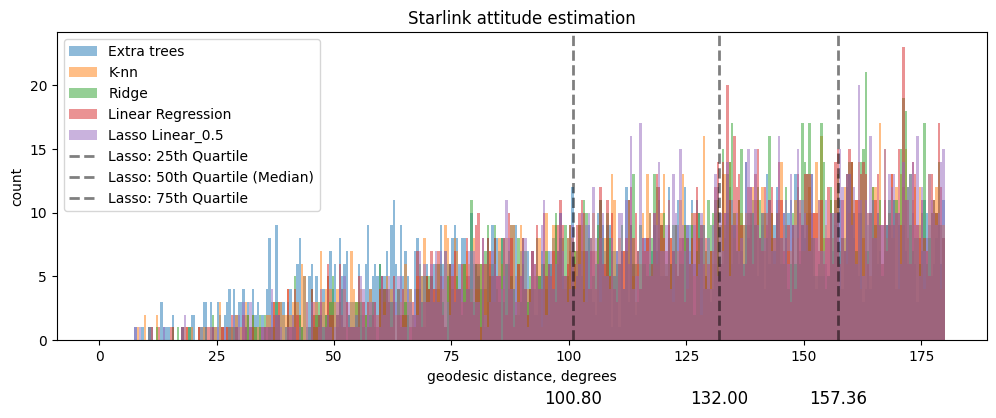

In [37]:

# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import sklearn
import matplotlib.pyplot as plt
import numpy as np

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    # "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    # "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}


# import numpy as np

# def normalize_quaternion(q):
#     norm = np.linalg.norm(q, axis=-1)
#     return q / norm[...,np.newaxis]

# def geodesic_rot_distance(target, pred):
# #     # return np.pi - np.arccos(2*np.square(np.sum(pred*target, axis=-1))-1)
# #     # target_c = target.copy()
# #     # target_c = normalize_quaternion(target_c)
# #     # pred_c = pred.copy()
# #     # pred_c = normalize_quaternion(pred_c)
#     pred = pred.copy()
#     pred = normalize_quaternion(pred)
#     target = target.copy()
#     target = normalize_quaternion(target)
#     return 1 - np.abs(np.sum(pred * target, axis=-1))
    # return np.pi - 2 * np.arccos(abs(np.sum(pred * target, axis=-1)))
# from pyquaternion import Quaternion




# import pyquaternion

# def cos( A, B ):
#     """ comment cos between vectors or matrices """
#     Aflat = A.reshape(-1)  # views
#     Bflat = B.reshape(-1)
#     return (np.dot( Aflat, Bflat )
#         / max( np.linalg.norm(Aflat) * np.linalg.norm(Bflat), 1e-10 ))


# def geodesic_rot_distance(target, pred):
#     # convert quaternions to rotation matrices
#     target = target.copy().tolist()
#     pred = pred.copy().tolist()

#     for i in range(len(target)):
#         target[i] = pyquaternion.Quaternion(target[i]).rotation_matrix
#         pred[i]   = pyquaternion.Quaternion(pred[i]).rotation_matrix

#     # calculate the distance according to rotation matrix
#     distances = []
#     for i in range(len(target)):
#         distances.append(cos(target[i], pred[i]))

#     return np.array(distances)


def geodesic_rot_distance(target, pred):
    target = target/np.linalg.norm(target, axis=-1, keepdims=True)
    pred = pred/np.linalg.norm(pred, axis=-1, keepdims=True)

    return np.arccos(np.clip(2*np.sum(target * pred, axis=-1)**2-1, -1, 1))

# 1 - np.abs(np.sum(pred * target, axis=-1))


# def geodesic_rot_distance(target, pred):
#     distances = []
#     for i in range(len(target)):
#         distances.append(Quaternion.distance(Quaternion(target[i]), Quaternion(pred[i])))
#     return np.array(distances)



########## DEFINE BINS

# Define the desired bin edges (minimum and maximum values)
min_bin = 0
max_bin = 180
bin_width = 0.5  # Adjust this value as needed

# Calculate the number of bins based on the range and bin width
num_bins = int((max_bin - min_bin) / bin_width)

y_test_predict = dict()
plt.figure(figsize=(12, 4))
for name, estimator in ESTIMATORS.items():
    estimator.fit(xvals[train_indices], y_vals[train_indices])
    y_test_predict[name] = estimator.predict(xvals[test_indices])
    print(f'geodesic distance, radians on test {name}', sklearn.metrics.mean_squared_error(y_vals[test_indices], y_test_predict[name], squared=False))
    data = np.abs(geodesic_rot_distance(y_vals[test_indices], y_test_predict[name]))*180/np.pi
    plt.hist(data, bins=num_bins, range=(min_bin, max_bin), alpha=0.5, label=name)
    
    if name == 'Lasso Linear_0.5':
        # Calculate QUARTILES values
        q25 = np.percentile(data, 25)
        q50 = np.percentile(data, 50)
        q75 = np.percentile(data, 75)

        # Add vertical lines for quartiles
        plt.axvline(q25, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Lasso: 25th Quartile')
        plt.axvline(q50, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Lasso: 50th Quartile (Median)')
        plt.axvline(q75, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Lasso: 75th Quartile')
        
        plt.text(q25, -5, f'{q25:.2f}', color='black', fontsize=12, ha='center')
        plt.text(q50, -5, f'{q50:.2f}', color='black', fontsize=12, ha='center')
        plt.text(q75, -5, f'{q75:.2f}', color='black', fontsize=12, ha='center')

    plt.title('Starlink attitude estimation')
    plt.xlabel('geodesic distance, degrees')
    plt.ylabel('count')
    plt.legend()
    # plt.show()

In [8]:
y_test_predict[name]

array([[ 0.00537065, -0.00138778, -0.00295926, -0.00159805],
       [ 0.00537065, -0.00138778, -0.0030375 , -0.00159805],
       [ 0.00537065, -0.00138778, -0.00661321, -0.00159805],
       ...,
       [ 0.00537065, -0.00138778, -0.00697394, -0.00159805],
       [ 0.00537065, -0.00138778, -0.0059761 , -0.00159805],
       [ 0.00537065, -0.00138778, -0.00699901, -0.00159805]],
      dtype=float32)

In [ ]:
# just using the bounding box
#### get png and json filepaths

import glob
import os
import re
from PIL import Image

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)

## get the translations (YVALS) from the json files

import os
import json
import numpy as np

translations = []
for json_f in json_files:
    with open(json_f) as f: translations.append(json.load(f)['pose'])

translations = np.array(translations, dtype=np.float32)
y_vals = translations


# extract dimensions (XVALS) from the data
from skimage.color import rgb2gray
def model_dimensions(img_np:np.ndarray):

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    try:
        ymin, ymax = np.min(y), np.max(y)
        xmin, xmax = np.min(x), np.max(x)
    except:
        ymin, ymax = 0, 0
        xmin, xmax = 0, 0
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = horiz_sums[horiz_sums>0.01]
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = vert_sums[vert_sums>0.01]
    vert_sums = [i for i in vert_sums]

    # turn the horizontal and vertical sums into a spline, and sample 20 points
    from scipy.interpolate import UnivariateSpline
    horiz_spline = UnivariateSpline(range(len(horiz_sums)), horiz_sums)
    vert_spline = UnivariateSpline(range(len(vert_sums)), vert_sums)
    horiz_spline.set_smoothing_factor(0.5)
    vert_spline.set_smoothing_factor(0.5)

    values_to_query = np.linspace(0, len(horiz_sums), 50)
    horiz_spline_vals = horiz_spline(values_to_query)

    values_to_query = np.linspace(0, len(vert_sums), 50)
    vert_spline_vals  = vert_spline(values_to_query)

    return [height, width, ymin, ymax, xmin, xmax] + list(horiz_spline_vals) + list(vert_spline_vals)


import tqdm
dimensions = []
for png_f in tqdm.tqdm(png_files, desc='loading x vals'):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
xvals = dimensions
